In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = r"C:\Users\shang\OneDrive\Documents\3IA\DW\prjt\dims\Sales.xlsx"
df = pd.read_excel(file_path)

df.head()


,code_sale,code_customer,order_code,SKU,code_ship_type,code_pricing_strategy,code_payment_method,quantity,prod_name,Estimated_Unit_Price,sale_date,is_discounted
0,S244495,2060,ORD405664,118458034,SHIP1209,TOPBAN0041,PAY1961,1,Jerry jogger bottoms,24.99,2023-02-02,0
1,S279244,125,ORD226537,118458034,SHIP4965,BOTH&M0012,PAY0503,3,Jerry jogger bottoms,24.99,2023-11-22,1
2,S519880,1989,ORD231649,144993001,SHIP4965,OUTZAR0031,PAY1985,1,Mama 100 den 1p Tights,7.99,2021-12-22,0
3,S395741,839,ORD613094,126589012,SHIP3159,OUTMAN0029,PAY4543,1,2p Claw,4.99,2023-11-01,0
4,S558471,1179,ORD435118,118458004,SHIP4965,SHOANN0032,PAY5626,2,Jerry jogger bottoms,24.99,2024-02-24,0


In [3]:
df.columns.tolist()


['code_sale',
 'code_customer',
 'order_code',
 'SKU',
 'code_ship_type',
 'code_pricing_strategy',
 'code_payment_method',
 'quantity',
 'prod_name',
 'Estimated_Unit_Price',
 'sale_date',
 'is_discounted']

In [4]:
df = df[['SKU', 'code_sale', 'sale_date', 'quantity', 'Estimated_Unit_Price']]
df = df.dropna()
df.head()


,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price
0,118458034,S244495,2023-02-02,1,24.99
1,118458034,S279244,2023-11-22,3,24.99
2,144993001,S519880,2021-12-22,1,7.99
3,126589012,S395741,2023-11-01,1,4.99
4,118458004,S558471,2024-02-24,2,24.99


In [5]:
# Convert to datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Compute min/max sale date per SKU
date_spread = df.groupby('SKU')['sale_date'].agg(['min', 'max']).reset_index()

# Calculate date flexibility as difference in days
date_spread['date_flexibility'] = (date_spread['max'] - date_spread['min']).dt.days

# Merge back to main dataframe
df = df.merge(date_spread[['SKU', 'date_flexibility']], on='SKU', how='left')
df.head()


,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price,date_flexibility
0,118458034,S244495,2023-02-02,1,24.99,1213
1,118458034,S279244,2023-11-22,3,24.99,1213
2,144993001,S519880,2021-12-22,1,7.99,1213
3,126589012,S395741,2023-11-01,1,4.99,1213
4,118458004,S558471,2024-02-24,2,24.99,1213


In [6]:
purchases = df.groupby('SKU')['code_sale'].nunique().reset_index()
purchases.columns = ['SKU', 'num_purchases']

df = df.merge(purchases, on='SKU', how='left')
df.head()


,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price,date_flexibility,num_purchases
0,118458034,S244495,2023-02-02,1,24.99,1213,3267
1,118458034,S279244,2023-11-22,3,24.99,1213,3267
2,144993001,S519880,2021-12-22,1,7.99,1213,3121
3,126589012,S395741,2023-11-01,1,4.99,1213,3312
4,118458004,S558471,2024-02-24,2,24.99,1213,3390


In [7]:
# Normalize features to 0-1 range for discount calculation
df['num_purchases_norm'] = (df['num_purchases'] - df['num_purchases'].min()) / (df['num_purchases'].max() - df['num_purchases'].min())
df['quantity_norm'] = (df['quantity'] - df['quantity'].min()) / (df['quantity'].max() - df['quantity'].min())
df['date_flexibility_norm'] = (df['date_flexibility'] - df['date_flexibility'].min()) / (df['date_flexibility'].max() - df['date_flexibility'].min())
df['price_norm'] = (df['Estimated_Unit_Price'] - df['Estimated_Unit_Price'].min()) / (df['Estimated_Unit_Price'].max() - df['Estimated_Unit_Price'].min())

df.head()

,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price,date_flexibility,num_purchases,num_purchases_norm,quantity_norm,date_flexibility_norm,price_norm
0,118458034,S244495,2023-02-02,1,24.99,1213,3267,0.560647,0.000000,0.10989,0.385965
1,118458034,S279244,2023-11-22,3,24.99,1213,3267,0.560647,0.666667,0.10989,0.385965
2,144993001,S519880,2021-12-22,1,7.99,1213,3121,0.167116,0.000000,0.10989,0.087719
3,126589012,S395741,2023-11-01,1,4.99,1213,3312,0.681941,0.000000,0.10989,0.035088
4,118458004,S558471,2024-02-24,2,24.99,1213,3390,0.892183,0.333333,0.10989,0.385965


In [8]:
np.random.seed(42)

# Normalize each component to a 0-1 range before summing
df['estimated_discount_percentage'] = (
    0.25 * df['num_purchases_norm'] +
    0.25 * df['quantity_norm'] +
    0.25 * df['date_flexibility_norm'] +
    0.25 * df['price_norm']
) * 100

# Add small Gaussian noise
df['estimated_discount_percentage'] += np.random.normal(0, 5, size=len(df))
df['estimated_discount_percentage'] = df['estimated_discount_percentage'].clip(0, 100)

df.head()


,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price,date_flexibility,num_purchases,num_purchases_norm,quantity_norm,date_flexibility_norm,price_norm,estimated_discount_percentage
0,118458034,S244495,2023-02-02,1,24.99,1213,3267,0.560647,0.000000,0.10989,0.385965,28.896119
1,118458034,S279244,2023-11-22,3,24.99,1213,3267,0.560647,0.666667,0.10989,0.385965,42.387893
2,144993001,S519880,2021-12-22,1,7.99,1213,3121,0.167116,0.000000,0.10989,0.087719,12.356575
3,126589012,S395741,2023-11-01,1,4.99,1213,3312,0.681941,0.000000,0.10989,0.035088,28.288113
4,118458004,S558471,2024-02-24,2,24.99,1213,3390,0.892183,0.333333,0.10989,0.385965,41.863524


In [9]:
encoder = LabelEncoder()
df['SKU_encoded'] = encoder.fit_transform(df['SKU'])
df.head()


,SKU,code_sale,sale_date,quantity,Estimated_Unit_Price,date_flexibility,num_purchases,num_purchases_norm,quantity_norm,date_flexibility_norm,price_norm,estimated_discount_percentage,SKU_encoded
0,118458034,S244495,2023-02-02,1,24.99,1213,3267,0.560647,0.000000,0.10989,0.385965,28.896119,20
1,118458034,S279244,2023-11-22,3,24.99,1213,3267,0.560647,0.666667,0.10989,0.385965,42.387893,20
2,144993001,S519880,2021-12-22,1,7.99,1213,3121,0.167116,0.000000,0.10989,0.087719,12.356575,39
3,126589012,S395741,2023-11-01,1,4.99,1213,3312,0.681941,0.000000,0.10989,0.035088,28.288113,32
4,118458004,S558471,2024-02-24,2,24.99,1213,3390,0.892183,0.333333,0.10989,0.385965,41.863524,17


In [10]:
X = df[['SKU_encoded', 'num_purchases', 'quantity', 'date_flexibility', 'Estimated_Unit_Price']]
y = df['estimated_discount_percentage']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [13]:
y_pred = model.predict(X_test)


In [14]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Squared Error: 25.06386800037174
R² Score: 0.7495324366336413


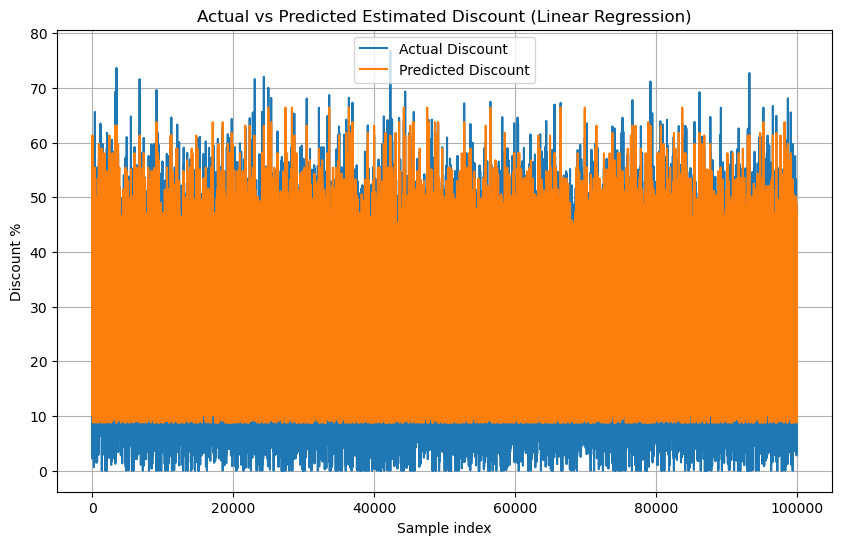

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(len(y_test)), y_test.values, label="Actual Discount")
plt.plot(range(len(y_pred)), y_pred, label="Predicted Discount")
plt.title("Actual vs Predicted Estimated Discount (Linear Regression)")
plt.xlabel("Sample index")
plt.ylabel("Discount %")
plt.legend()
plt.grid(True)
plt.show()


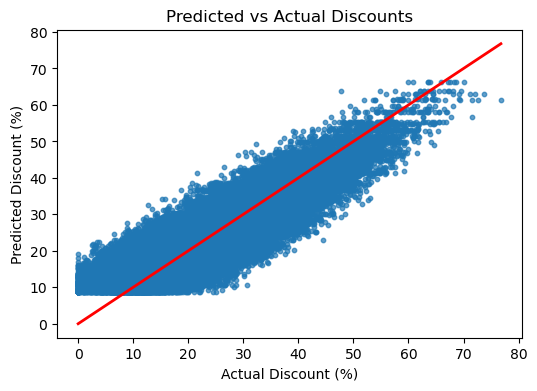

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, s=10, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel("Actual Discount (%)")
plt.ylabel("Predicted Discount (%)")
plt.title("Predicted vs Actual Discounts")
plt.show()

In [17]:
# Initialize multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print()

Linear Regression:
  Mean Squared Error: 25.0639
  R² Score: 0.7495

Decision Tree:
  Mean Squared Error: 25.0882
  R² Score: 0.7493

Decision Tree:
  Mean Squared Error: 25.0882
  R² Score: 0.7493

Random Forest:
  Mean Squared Error: 25.0881
  R² Score: 0.7493

Random Forest:
  Mean Squared Error: 25.0881
  R² Score: 0.7493

XGBoost:
  Mean Squared Error: 25.0870
  R² Score: 0.7493

XGBoost:
  Mean Squared Error: 25.0870
  R² Score: 0.7493

KNN:
  Mean Squared Error: 30.0963
  R² Score: 0.6992

KNN:
  Mean Squared Error: 30.0963
  R² Score: 0.6992



In [18]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['MSE'] for m in results.keys()],
    'R² Score': [results[m]['R2'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print("\n" + "="*50)
print("MODEL COMPARISON (Sorted by R² Score)")
print("="*50)
print(comparison_df.to_string(index=False))
print("\nBest Model:", comparison_df.iloc[0]['Model'])


MODEL COMPARISON (Sorted by R² Score)
            Model       MSE  R² Score
Linear Regression 25.063868  0.749532
          XGBoost 25.086950  0.749302
    Random Forest 25.088053  0.749291
    Decision Tree 25.088152  0.749290
              KNN 30.096282  0.699243

Best Model: Linear Regression


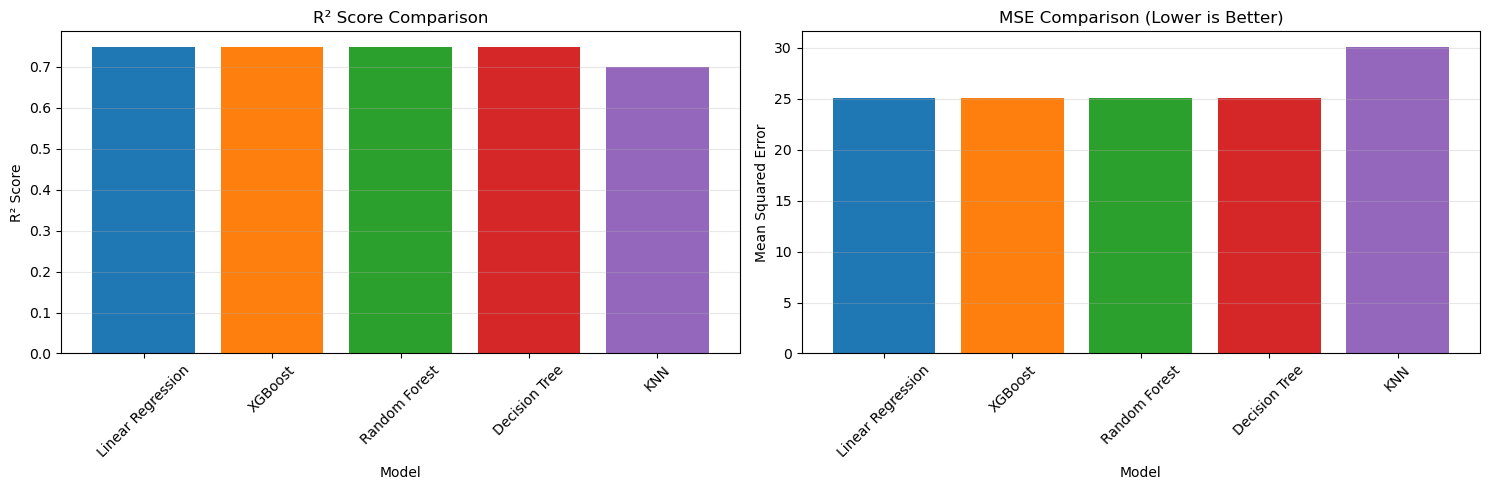

In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart for R² scores
axes[0].bar(comparison_df['Model'], comparison_df['R² Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Bar chart for MSE
axes[1].bar(comparison_df['Model'], comparison_df['MSE'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Comparison (Lower is Better)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

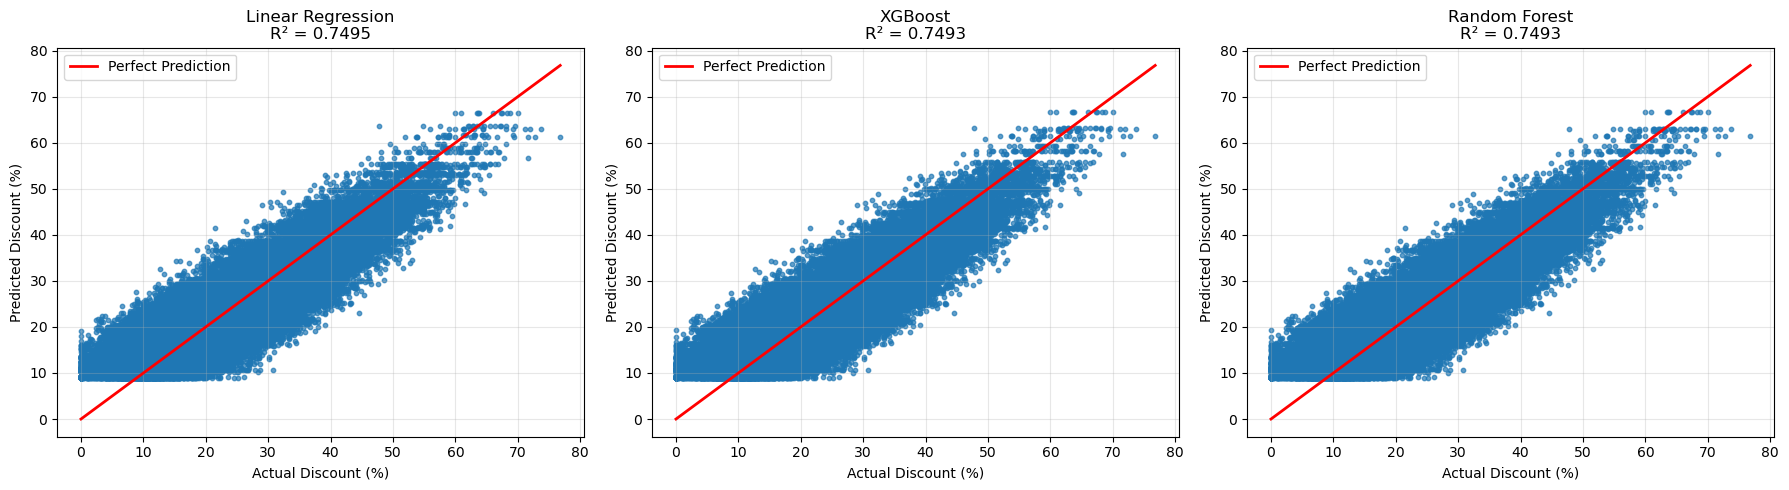

In [20]:
# Scatter plots for best 3 models
best_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(best_models):
    y_pred = results[model_name]['predictions']
    r2 = results[model_name]['R2']
    
    axes[idx].scatter(y_test, y_pred, s=10, alpha=0.7)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                   color='red', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Discount (%)')
    axes[idx].set_ylabel('Predicted Discount (%)')
    axes[idx].set_title(f'{model_name}\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Feature Engineering: Create interaction features
X_enhanced = X.copy()
X_enhanced['price_quantity'] = X['Estimated_Unit_Price'] * X['quantity']
X_enhanced['purchases_flexibility'] = X['num_purchases'] * X['date_flexibility']
X_enhanced['price_purchases'] = X['Estimated_Unit_Price'] * X['num_purchases']

print("Original features:", X.shape[1])
print("Enhanced features:", X_enhanced.shape[1])
print("\nNew feature columns:")
print(X_enhanced.columns.tolist())

Original features: 5
Enhanced features: 8

New feature columns:
['SKU_encoded', 'num_purchases', 'quantity', 'date_flexibility', 'Estimated_Unit_Price', 'price_quantity', 'purchases_flexibility', 'price_purchases']


In [22]:
# Feature Scaling: Standardize features
scaler = StandardScaler()
X_enhanced_train, X_enhanced_test, y_train_new, y_test_new = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42
)

X_train_scaled = scaler.fit_transform(X_enhanced_train)
X_test_scaled = scaler.transform(X_enhanced_test)

print("Features scaled successfully!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Features scaled successfully!
Training set: (399998, 8)
Test set: (100000, 8)


In [23]:
# Advanced models with optimized hyperparameters
optimized_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree (Tuned)': DecisionTreeRegressor(
        max_depth=10, 
        min_samples_split=20, 
        min_samples_leaf=10,
        random_state=42
    ),
    'Random Forest (Tuned)': RandomForestRegressor(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'XGBoost (Tuned)': xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    'KNN (Tuned)': KNeighborsRegressor(n_neighbors=10, weights='distance')
}

print("Models initialized with optimized hyperparameters!")

Models initialized with optimized hyperparameters!


In [24]:
# Train and evaluate optimized models
optimized_results = {}

for name, model in optimized_models.items():
    # Train the model
    model.fit(X_train_scaled, y_train_new)
    
    # Make predictions
    y_pred_opt = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_new, y_pred_opt)
    r2 = r2_score(y_test_new, y_pred_opt)
    
    # Cross-validation score (5-fold)
    cv_scores = cross_val_score(model, X_train_scaled, y_train_new, 
                                 cv=5, scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    optimized_results[name] = {
        'MSE': mse,
        'R2': r2,
        'CV_Mean': cv_mean,
        'CV_Std': cv_std,
        'predictions': y_pred_opt
    }
    
    print(f"{name}:")
    print(f"  Test R² Score: {r2:.4f}")
    print(f"  CV R² Score: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print(f"  MSE: {mse:.4f}")
    print()

Linear Regression:
  Test R² Score: 0.7495
  CV R² Score: 0.7494 (+/- 0.0013)
  MSE: 25.0638

Ridge Regression:
  Test R² Score: 0.7495
  CV R² Score: 0.7494 (+/- 0.0013)
  MSE: 25.0638

Ridge Regression:
  Test R² Score: 0.7495
  CV R² Score: 0.7494 (+/- 0.0013)
  MSE: 25.0638

Lasso Regression:
  Test R² Score: 0.7491
  CV R² Score: 0.7490 (+/- 0.0012)
  MSE: 25.1090

Lasso Regression:
  Test R² Score: 0.7491
  CV R² Score: 0.7490 (+/- 0.0012)
  MSE: 25.1090

Decision Tree (Tuned):
  Test R² Score: 0.7486
  CV R² Score: 0.7480 (+/- 0.0013)
  MSE: 25.1580

Decision Tree (Tuned):
  Test R² Score: 0.7486
  CV R² Score: 0.7480 (+/- 0.0013)
  MSE: 25.1580

Random Forest (Tuned):
  Test R² Score: 0.7493
  CV R² Score: 0.7489 (+/- 0.0013)
  MSE: 25.0878

Random Forest (Tuned):
  Test R² Score: 0.7493
  CV R² Score: 0.7489 (+/- 0.0013)
  MSE: 25.0878

Gradient Boosting:
  Test R² Score: 0.7493
  CV R² Score: 0.7490 (+/- 0.0013)
  MSE: 25.0838

Gradient Boosting:
  Test R² Score: 0.7493
  CV 

In [25]:
# Comprehensive comparison: Original vs Optimized
comparison_opt = pd.DataFrame({
    'Model': list(optimized_results.keys()),
    'Test R²': [optimized_results[m]['R2'] for m in optimized_results.keys()],
    'CV R²': [optimized_results[m]['CV_Mean'] for m in optimized_results.keys()],
    'MSE': [optimized_results[m]['MSE'] for m in optimized_results.keys()]
})

comparison_opt = comparison_opt.sort_values('Test R²', ascending=False)
print("\n" + "="*70)
print("OPTIMIZED MODEL COMPARISON (with Feature Engineering & Scaling)")
print("="*70)
print(comparison_opt.to_string(index=False))
print("\n🏆 Best Model:", comparison_opt.iloc[0]['Model'])
print(f"   Test R²: {comparison_opt.iloc[0]['Test R²']:.4f}")
print(f"   CV R²: {comparison_opt.iloc[0]['CV R²']:.4f}")


OPTIMIZED MODEL COMPARISON (with Feature Engineering & Scaling)
                Model  Test R²    CV R²       MSE
    Linear Regression 0.749533 0.749427 25.063780
     Ridge Regression 0.749533 0.749427 25.063805
      XGBoost (Tuned) 0.749336 0.748970 25.083521
    Gradient Boosting 0.749333 0.749014 25.083785
Random Forest (Tuned) 0.749293 0.748891 25.087792
     Lasso Regression 0.749081 0.748971 25.109036
Decision Tree (Tuned) 0.748592 0.747996 25.157968
          KNN (Tuned) 0.723381 0.723833 27.680807

🏆 Best Model: Linear Regression
   Test R²: 0.7495
   CV R²: 0.7494


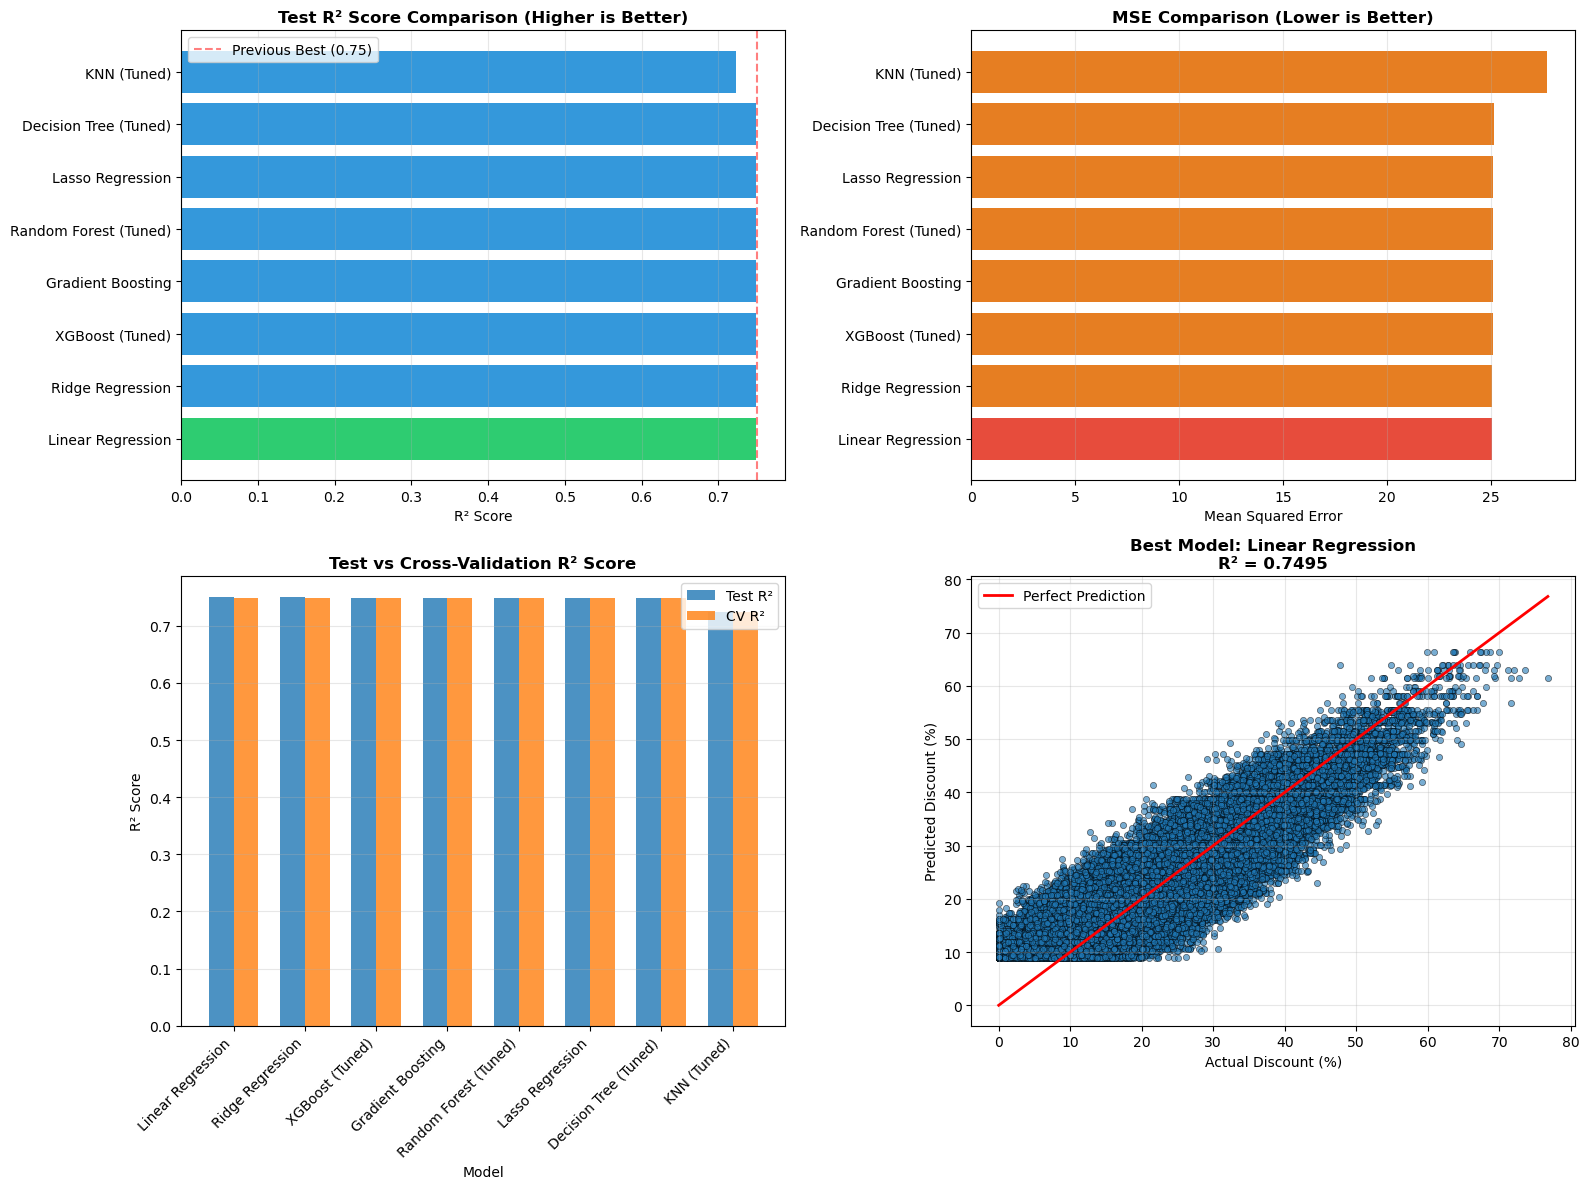

In [29]:
# Visualization: Optimized models performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Score comparison
axes[0, 0].barh(comparison_opt['Model'], comparison_opt['Test R²'], 
                color=['#2ecc71' if i == 0 else '#3498db' for i in range(len(comparison_opt))])
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Test R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='Previous Best (0.75)')
axes[0, 0].legend()

# 2. MSE comparison
axes[0, 1].barh(comparison_opt['Model'], comparison_opt['MSE'], 
                color=['#e74c3c' if i == 0 else '#e67e22' for i in range(len(comparison_opt))])
axes[0, 1].set_xlabel('Mean Squared Error')
axes[0, 1].set_title('MSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Test vs CV R² scores
x_pos = np.arange(len(comparison_opt))
width = 0.35
axes[1, 0].bar(x_pos - width/2, comparison_opt['Test R²'], width, label='Test R²', alpha=0.8)
axes[1, 0].bar(x_pos + width/2, comparison_opt['CV R²'], width, label='CV R²', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Test vs Cross-Validation R² Score', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(comparison_opt['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Best model prediction scatter
best_model_name = comparison_opt.iloc[0]['Model']
best_predictions = optimized_results[best_model_name]['predictions']
best_r2 = optimized_results[best_model_name]['R2']

axes[1, 1].scatter(y_test_new, best_predictions, s=20, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1, 1].plot([y_test_new.min(), y_test_new.max()], 
                [y_test_new.min(), y_test_new.max()], 
                color='red', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Discount (%)')
axes[1, 1].set_ylabel('Predicted Discount (%)')
axes[1, 1].set_title(f'Best Model: {best_model_name}\nR² = {best_r2:.4f}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

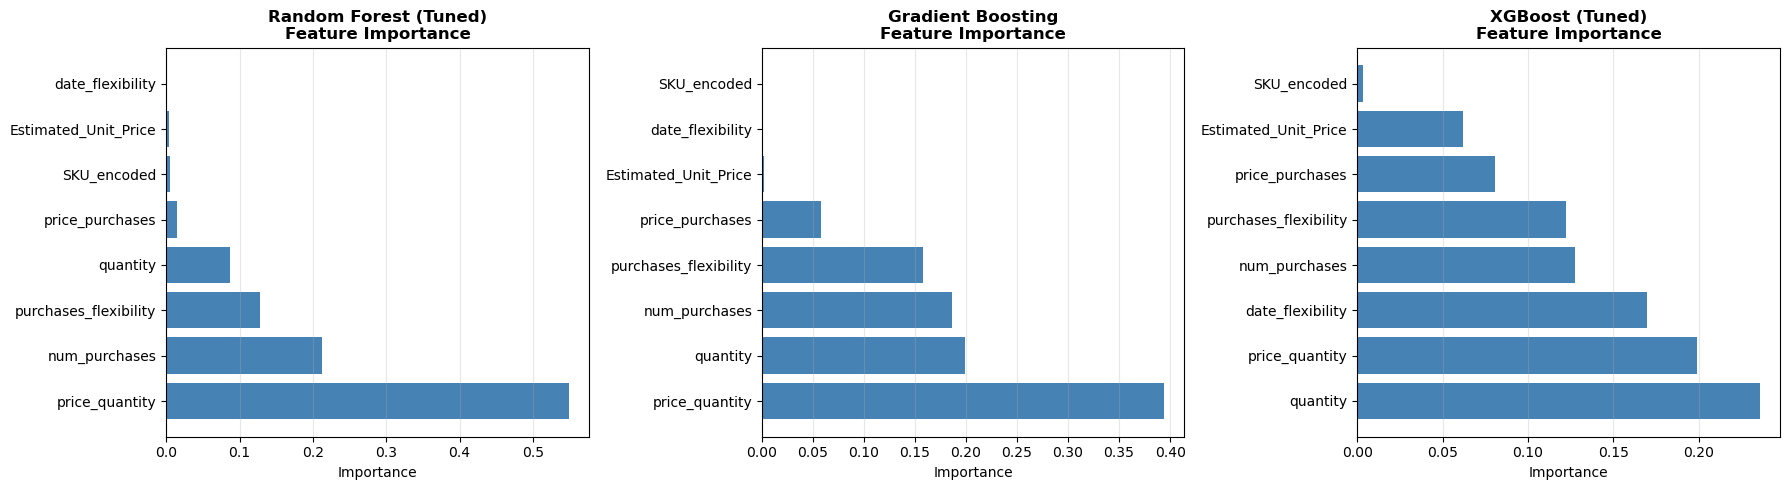

In [32]:
# Feature importance for the best tree-based model
best_tree_models = ['Random Forest (Tuned)', 'Gradient Boosting', 'XGBoost (Tuned)']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(best_tree_models):
    if model_name in optimized_results:
        model = optimized_models[model_name]
        
        # Get feature importances
        importances = model.feature_importances_
        feature_names = X_enhanced.columns
        
        # Sort by importance
        indices = np.argsort(importances)[::-1]
        
        # Plot
        axes[idx].barh(range(len(importances)), importances[indices], color='steelblue')
        axes[idx].set_yticks(range(len(importances)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices])
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()